In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
import numpy as np

In [2]:
# Parameters
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 7
EPOCHS = 25


dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'Dataset',
    shuffle=True,
    image_size=(IMAGE_SIZE),
    batch_size=BATCH_SIZE
)
class_name=dataset.class_names
class_name
print(class_name)

# Directories
train_dir = 'Dataset/train'
val_dir = 'Dataset/val'
test_dir = 'Dataset/test'

Found 6042 files belonging to 7 classes.
['bacterial_blight', 'curl_virus', 'fussarium_wilt', 'healthy', 'test', 'train', 'val']


In [3]:
def get_dataset_preparation_tf(ds,train_split = 0.8,val_split = 0.1,test_split =0.1,shuffle = True,shuffle_size = 1000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed = 12)
    train_size = int(train_split*ds_size)
    val_size = int(val_split * ds_size)
    test_size = int(test_split * ds_size)
    train_dir = ds.take(train_size)
    val_dir = ds.skip(train_size).take(val_size)
    test_dir = ds.skip(train_size + val_size).take(test_size)
    return train_dir,val_dir,test_dir

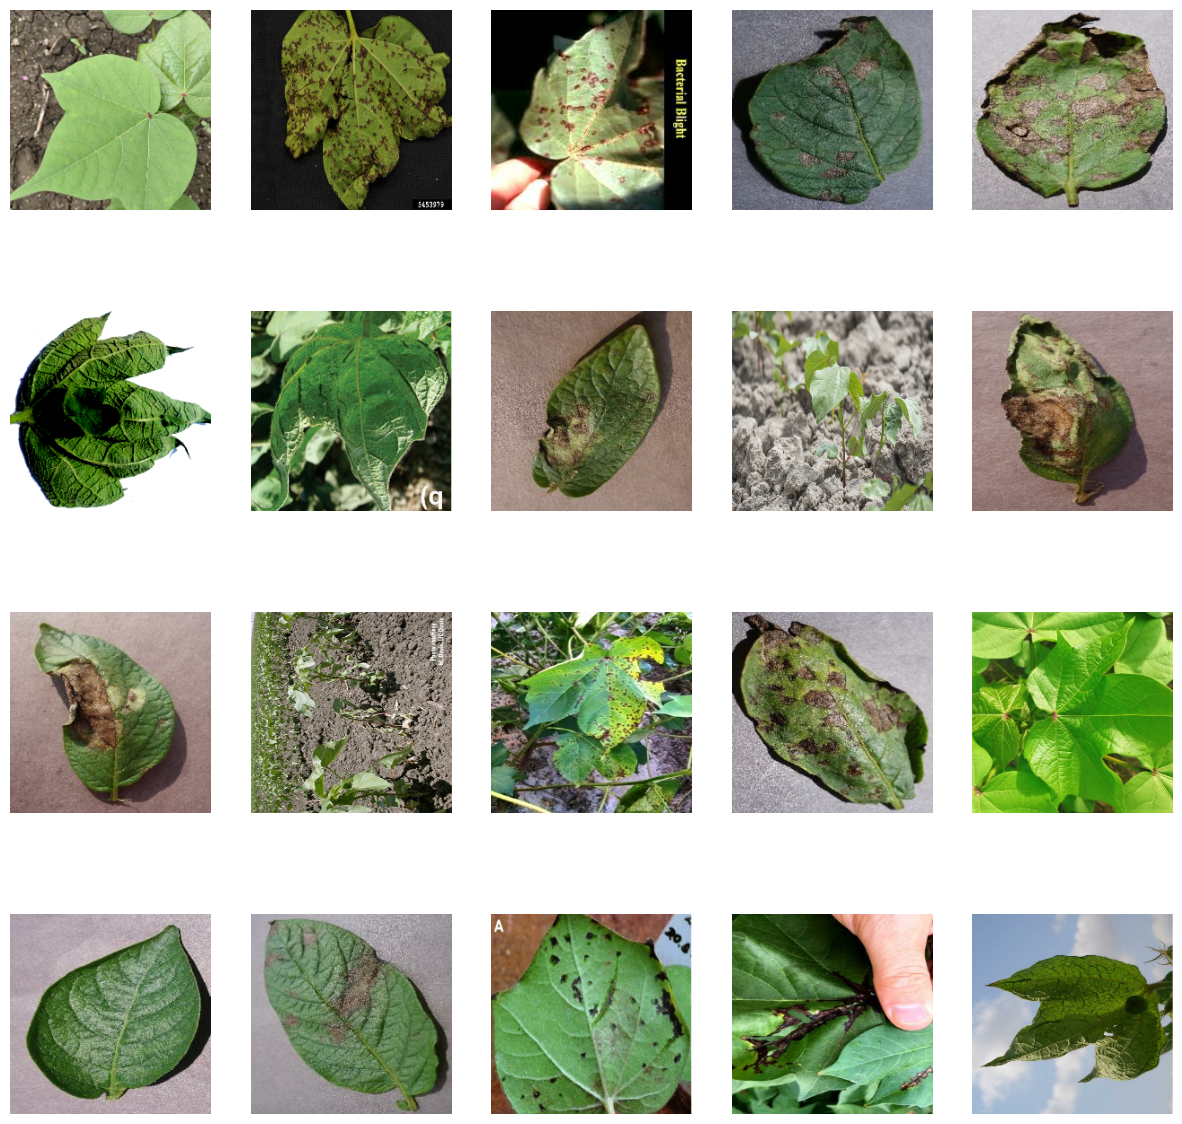

In [4]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(15,15))
for image_batch,label_batch in dataset.take(1):
    for i in range(0,20):
        ax = plt.subplot(4,5,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")

In [5]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

test_generator = val_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


Found 2467 images belonging to 7 classes.
Found 615 images belonging to 7 classes.
Found 470 images belonging to 7 classes.


In [6]:
# Load MobileNetV2 model with pretrained weights
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Adding custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# Final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freezing the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    epochs=EPOCHS
)

# # Unfreeze some layers and fine-tune the model
# for layer in base_model.layers[:100]:
#     layer.trainable = False
# for layer in base_model.layers[100:]:
#     layer.trainable = True

# # Re-compile the model with a lower learning rate
# model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

# # Continue training
# history_fine = model.fit(
#     train_generator,
#     steps_per_epoch=train_generator.samples // BATCH_SIZE,
#     validation_data=val_generator,
#     validation_steps=val_generator.samples // BATCH_SIZE,
#     epochs=EPOCHS // 2
# )


Epoch 1/25


C:\Users\jayesh\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


77/77 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.7053 - loss: 1.4961 - val_accuracy: 0.9490 - val_loss: 0.1267
Epoch 2/25
 1/77 ━━━━━━━━━━━━━━━━━━━━ 47s 626ms/step - accuracy: 0.9062 - loss: 0.2358

C:\Users\jayesh\anaconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9062 - loss: 0.2358 - val_accuracy: 0.8571 - val_loss: 0.8462
Epoch 3/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.9162 - loss: 0.2599 - val_accuracy: 0.9194 - val_loss: 0.3081
Epoch 4/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9375 - loss: 0.2036 - val_accuracy: 1.0000 - val_loss: 0.0159
Epoch 5/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 78s 996ms/step - accuracy: 0.9530 - loss: 0.1785 - val_accuracy: 0.9408 - val_loss: 0.1562
Epoch 6/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 0.0254 - val_accuracy: 1.0000 - val_loss: 0.0149
Epoch 7/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.9646 - loss: 0.1104 - val_accuracy: 0.9490 - val_loss: 0.1719
Epoch 8/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9375 - loss: 0.2118 - val_accuracy: 1.0000 - val_loss: 0.0119
Epoch 9/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.9670 - loss: 0.0978 - val_accuracy: 0.9375 - val_loss: 0.3555

In [7]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE)
print(f'Test accuracy: {test_acc}')

# Save the model
model.save('cotton_disease_and_potato_model.h5')

# Load the model
model = tf.keras.models.load_model('cotton_disease_and_potato_model.h5')

14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 690ms/step - accuracy: 0.9400 - loss: 0.1838


Test accuracy: 0.9352678656578064


In [13]:
def predict_image(image_path):
    img = image.load_img(image_path, target_size=IMAGE_SIZE)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.

    prediction = model.predict(img_array)
    class_idx = np.argmax(prediction, axis=1)[0]
    class_labels =['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy','Cotton_bacterial_blight', 'Cotton_curl_virus', 'Cotton_fussarium_wilt', 'Cotton_healthy']
    return class_labels[class_idx]

# Example prediction

image_path = 'Dataset/test/curl_virus/curl110.jpg'
predicted_class = predict_image(image_path)
print(f'The predicted class is: {predicted_class}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
The predicted class is: Cotton_curl_virus
